# Introduction

In this notebook we probe into the DeiT attention weights.

Reference: [Sayak Paul's DeiT tfhub](https://tfhub.dev/sayakpaul/collections/deit/1)

In [1]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt -O ilsvrc2012_wordnet_lemmas.txt

--2022-04-04 11:15:08--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-04-04 11:15:08 (136 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



# Imports and Setups

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2

# Chose the DeiT model

In [18]:
model_name = "deit_base_distilled_patch16_224" #@param ["deit_tiny_patch16_224", "deit_tiny_distilled_patch16_224", "deit_small_patch16_224", "deit_small_distilled_patch16_224", "deit_base_patch16_224", "deit_base_distilled_patch16_224", "deit_base_patch16_384", "deit_base_distilled_patch16_384"]

model_handle_map ={
    "deit_tiny_patch16_224": "https://tfhub.dev/sayakpaul/deit_tiny_patch16_224/1",
    "deit_tiny_distilled_patch16_224": "https://tfhub.dev/sayakpaul/deit_tiny_distilled_patch16_224/1",
    "deit_small_patch16_224": "https://tfhub.dev/sayakpaul/deit_small_patch16_224/1",
    "deit_small_distilled_patch16_224": "https://tfhub.dev/sayakpaul/deit_small_distilled_patch16_224/1",
    "deit_base_patch16_224": "https://tfhub.dev/sayakpaul/deit_base_patch16_224/1",
    "deit_base_distilled_patch16_224": "https://tfhub.dev/sayakpaul/deit_base_distilled_patch16_224/1",
    "deit_base_patch16_384": "https://tfhub.dev/sayakpaul/deit_base_patch16_384/1",
    "deit_base_distilled_patch16_384": "https://tfhub.dev/sayakpaul/deit_base_distilled_patch16_384/1",

}


# derive the patch size, image resolution, and class tokens from the model name
splits = model_name.split("_")
input_resolution = int(splits[-1])
patch_size = int(splits[-2].replace("patch", ""))
num_cls_tokens = 2 if "distilled" in model_name else 1

# get the model handle
model_handle = model_handle_map[model_name]

print(f"Patch Size: {patch_size}.")
print(f"Input resolution: {input_resolution} x {input_resolution} x 3.")
print(f"TF-Hub handle: {model_handle}.")
print(f"Number of class tokens: {num_cls_tokens}.")

Patch Size: 16.
Input resolution: 224 x 224 x 3.
TF-Hub handle: https://tfhub.dev/sayakpaul/deit_base_distilled_patch16_224/1.
Number of class tokens: 2.


# Preprocessing the test image

In [19]:
crop_layer = keras.layers.CenterCrop(input_resolution, input_resolution)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)


def preprocess_image(image, size=input_resolution):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)
    resize_size = int((256 / 224) * size)
    image_resized = tf.image.resize(image_resized, (resize_size, resize_size), method="bicubic")
    image_resized = crop_layer(image_resized)
    return norm_layer(image_resized).numpy()
    

def load_image_from_url(url):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image

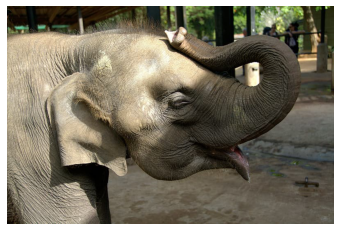

In [20]:
with open("ilsvrc2012_wordnet_lemmas.txt", "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image, preprocessed_image = load_image_from_url(img_url)

plt.imshow(image)
plt.axis("off")
plt.show()

# Run inference

In [21]:
def get_model(model_url: str) -> tf.keras.Model:
    inputs = tf.keras.Input((input_resolution, input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)

    outputs, _ = hub_module(inputs) # Second output in the tuple is a dictionary containing attention scores.

    return tf.keras.Model(inputs, outputs)

In [22]:
classification_model = get_model(model_handle)
predictions = classification_model.predict(preprocessed_image)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

Indian_elephant, Elephas_maximus


# Probing into the attention weights

In [23]:
loaded_model = tf.keras.models.load_model(
    f"gs://tfhub-modules/sayakpaul/{model_name}/1/uncompressed"
)
logits, attention_score_dict = loaded_model(preprocessed_image)
attention_score_dict.keys()

dict_keys(['transformer_block_2_att', 'transformer_block_5_att', 'transformer_block_9_att', 'transformer_block_3_att', 'transformer_block_10_att', 'transformer_block_11_att', 'transformer_block_0_att', 'transformer_block_4_att', 'transformer_block_1_att', 'transformer_block_7_att', 'transformer_block_8_att', 'transformer_block_6_att'])

In [24]:
# Stack the individual attention matrices from individual transformer blocks.
attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
attn_mat = tf.squeeze(attn_mat, axis=1)
print(attn_mat.shape)

# Average the attention weights across all heads.
attn_mat = tf.reduce_mean(attn_mat, axis=1)
print(attn_mat.shape)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_attn = tf.eye(attn_mat.shape[1])
aug_attn_mat = attn_mat + residual_attn
aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
aug_attn_mat = aug_attn_mat.numpy()
print(aug_attn_mat.shape)

# Recursively multiply the weight matrices
joint_attentions = np.zeros(aug_attn_mat.shape)
joint_attentions[0] = aug_attn_mat[0]

for n in range(1, aug_attn_mat.shape[0]):
    joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
result = (mask * image).astype("uint8")
print(result.shape)

(12, 12, 198, 198)
(12, 198, 198)
(12, 198, 198)
(533, 800, 3)


## Visualize the attention maps

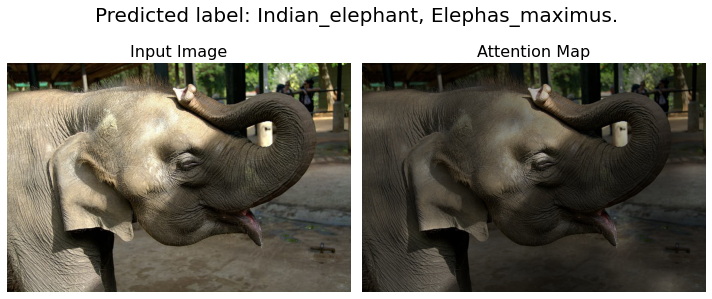

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

## Mean Attention Distance

Reference: https://gist.github.com/simonster/155894d48aef2bd36bd2dd8267e62391

In [26]:
def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j: # zero distance
                continue

            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size*np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix

def compute_mean_attention_dist(patch_size, attention_weights):
    attention_weights = attention_weights[..., num_cls_tokens:, num_cls_tokens:] # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    mean_distances = attention_weights*distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
    mean_distances = np.mean(mean_distances, axis=-1) # now average across all the tokens

    return mean_distances

In [27]:
# Build the mean distances for every transformer block
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(patch_size=patch_size, attention_weights=attention_weight)
    for name, attention_weight in attention_score_dict.items()
}

In [28]:
# get the number of heads from the mean distance output
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

# print the shapes
print(f"Num Heads: {num_heads}")

Num Heads: 12


## Visualize the mean distances

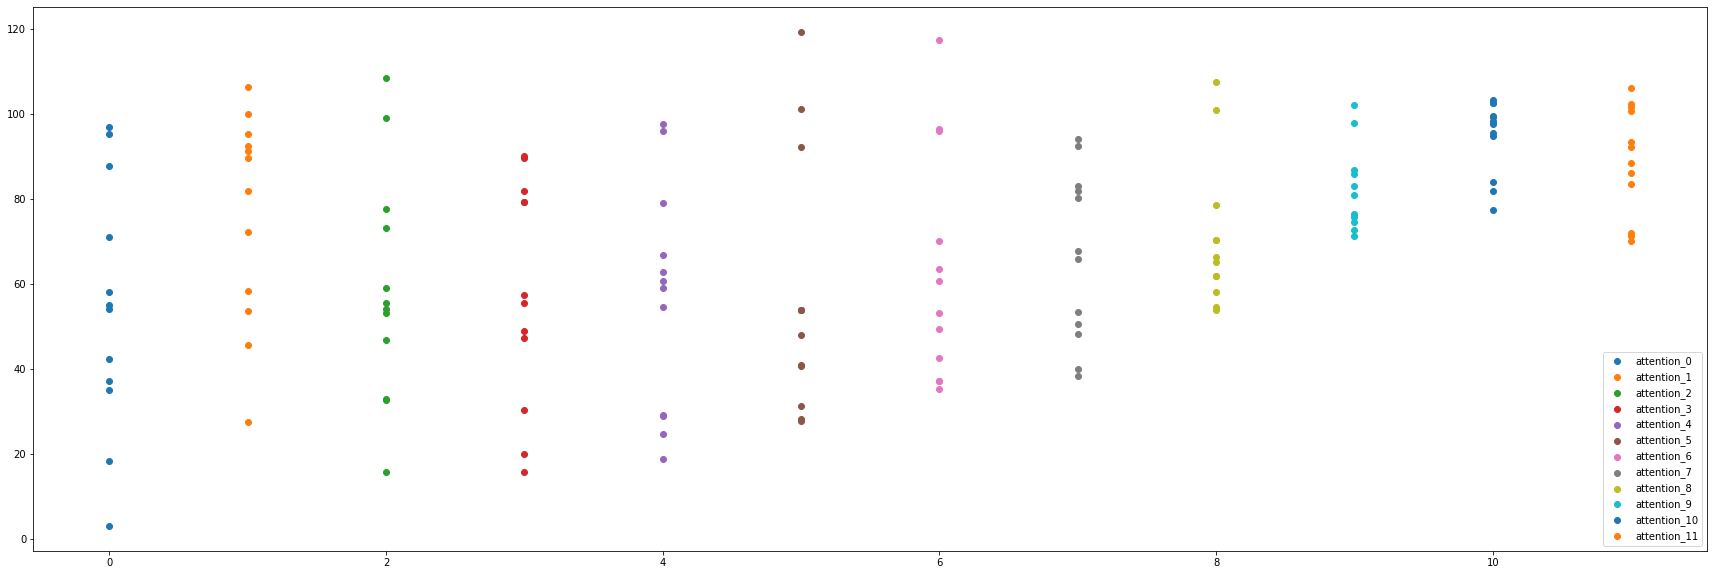

In [29]:
plt.figure(figsize=(30, 10))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"attention_{idx}")

plt.legend()
plt.show()